<center>
  
## Predict, Refine, Synthesize: Self-Guiding Diffusion Models for Probabilistic Time Series Forecasting

</center>


The paper proposes TSDiff, an unconditionally-trained diffusion model for time series. TSDiff utilizes a self-guidance mechanism that allows it to conditionally generate forecasts, refine predictions, and produce synthetic data without requiring auxiliary networks or altering the training procedure.

Time series forecasting is crucial for making informed decisions in various fields such as finance, energy, and healthcare. Traditional deep learning models approach this problem through conditional generative modeling. The paper introduces TSDiff, an unconditional diffusion model for time series, which can handle multiple downstream tasks. The self-guidance mechanism allows TSDiff to perform predictive tasks during inference without conditional training. The model's generative capabilities are also leveraged to improve the accuracy of base forecasters and generate high-quality synthetic data.

In the following, we will take a deeper dive to the implementation of this method.

# Imports and Setup

In this section, we import all necessary libraries and modules required for setting up the environment. This includes libraries for logging, parsing arguments, handling file paths, and loading configurations. Additionally, we import essential packages for data loading, model creation, and training such as PyTorch, PyTorch Lightning, and GluonTS. Custom modules specific to the time series diffusion model (TSDiff) are also imported.

In [1]:
import logging
import os
import argparse
from pathlib import Path

import yaml
import torch
from tqdm.auto import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

from gluonts.dataset.loader import TrainDataLoader
from gluonts.dataset.split import OffsetSplitter
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.field_names import FieldName

import uncond_ts_diff.configs as diffusion_configs
from uncond_ts_diff.dataset import get_gts_dataset
from uncond_ts_diff.model.callback import EvaluateCallback
from uncond_ts_diff.model import TSDiff
from uncond_ts_diff.sampler import DDPMGuidance, DDIMGuidance
from uncond_ts_diff.utils import (
    create_transforms,
    create_splitter,
    add_config_to_argparser,
    filter_metrics,
    MaskInput,
)

Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.
Falling back on slow Vandermonde kernel. Install pykeops for improved memory efficiency.


# Load Configuration

Here, we set up the configuration for the model training. This involves loading the configuration file which contains parameters and settings needed for the training process. The configuration is read from a YAML file and parsed into a dictionary format. Logging is also configured in this section to record the training process.

In [2]:
# Setup Logger
logging.basicConfig(
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger("logger")
logger.setLevel(logging.INFO)

# Setup config
config_path = "configs/train_tsdiff/train_uber_tlc.yaml"
log_dir = "./"

with open(config_path, "r") as fp:
    config = yaml.safe_load(fp)

# Model Creation

**TSDiff Model Architecture**

TSDiff is designed for univariate time series and uses S4 layers for temporal modeling. The architecture incorporates historical information by appending lagged time series along the channel dimension, allowing it to handle noisy inputs. The model's output dimensions match its input dimensions, making it suitable for unconditional generative tasks.

![TSDiff Model Architecture](figures/model_figure.png)

The following cells focuses on creating the TSDiff model based on the loaded configuration. A function create_model is defined which initializes the TSDiff model with parameters such as frequency, feature usage, normalization, context length, prediction length, and learning rate. The model is then moved to the specified device (CPU or GPU). Below is a detailed explanation of the input parameters:

**`diffusion_configs`**:
   - This is a module or an object containing various diffusion configurations. The specific configuration to use is specified by `config["diffusion_config"]`.

**`config["diffusion_config"]`**:
   - A string that specifies which diffusion configuration to use from `diffusion_configs`. This string is used with `getattr` to dynamically fetch the appropriate configuration.

**`freq`**:
   - `config["freq"]`: The frequency of the time series data (e.g., daily, hourly). This helps the model understand the time granularity of the input data.

**`use_features`**:
   - `config["use_features"]`: A boolean indicating whether to use additional features apart from the time series data. These could be features like categorical variables or other covariates.

**`use_lags`**:
   - `config["use_lags"]`: A boolean indicating whether to use lagged values of the time series as inputs. Lagged values can provide important temporal context for forecasting.

**`normalization`**:
   - `config["normalization"]`: Specifies the normalization technique to be applied to the time series data. Normalization can help in stabilizing the training process.

**`context_length`**:
   - `config["context_length"]`: The length of the historical context window used for making predictions. This determines how much past data the model considers when forecasting future values.

**`prediction_length`**:
   - `config["prediction_length"]`: The length of the forecast horizon. This specifies how many time steps ahead the model is expected to predict.

**`lr`**:
   - `config["lr"]`: The learning rate for the model's optimizer. This controls the step size during the gradient descent optimization process.

**`init_skip`**:
   - `config["init_skip"]`: A parameter that may be used to control the initialization or skipping of certain model components during training or inference.

**`device`**:
   - `config["device"]`: The device on which the model will be trained or run, typically "cpu" or "cuda" (for GPU acceleration).

In [4]:
def create_model(config):
    model = TSDiff(
        **getattr(diffusion_configs, config["diffusion_config"]),
        freq=config["freq"],
        use_features=config["use_features"],
        use_lags=config["use_lags"],
        normalization=config["normalization"],
        context_length=config["context_length"],
        prediction_length=config["prediction_length"],
        lr=config["lr"],
        init_skip=config["init_skip"],
    )
    model.to(config["device"])
    return model

In [5]:
# Create model
model = create_model(config)

# Data Loading and Preprocessing

In this section, the dataset is loaded and preprocessed based on the configuration settings. The dataset's metadata is validated to ensure consistency with the expected frequency and prediction length. Depending on the setup (forecasting or missing values), the appropriate data split is performed. Transformations and data loaders are also set up to facilitate the training process.

In [6]:
# Load parameters
dataset_name = config["dataset"]
freq = config["freq"]
context_length = config["context_length"]
prediction_length = config["prediction_length"]
total_length = context_length + prediction_length

# Setup dataset and data loading
dataset = get_gts_dataset(dataset_name)
assert dataset.metadata.freq == freq
assert dataset.metadata.prediction_length == prediction_length

# These lines check if the setup is for forecasting or predicting the missing values.
if config["setup"] == "forecasting":
    training_data = dataset.train
elif config["setup"] == "missing_values":
    # This line creates an instance of OffsetSplitter with a specified offset. 
    # The offset determines where the training data ends. 
    # A negative offset means that the training data will exclude a certain number 
    # of observations from the end of each series.
    missing_values_splitter = OffsetSplitter(offset=-total_length)
    training_data, _ = missing_values_splitter.split(dataset.train)

# The purpose of this line is to determine the number of rolling evaluations 
# that can be performed using the test and training datasets.
# In the context of time series forecasting, rolling evaluation is a method 
# where multiple models are trained and evaluated on different segments of the data. 
# Each evaluation uses a different starting point in the time series 
# to test the model's performance over time.
# By determining how many times the training dataset length fits into the test dataset length,
# this calculation helps set up multiple evaluation windows or periods over the test data.
num_rolling_evals = int(len(dataset.test) / len(dataset.train))

transformation = create_transforms(
    num_feat_dynamic_real=0, # number of dynamic real-valued features in the dataset
    num_feat_static_cat=0, # number of static categorical features in the dataset
    num_feat_static_real=0, # number of static real-valued features in the dataset
    time_features=model.time_features, # time-related features used by the model, such as day of the week, month, etc.
    prediction_length=config["prediction_length"], # length of the prediction horizon
)

training_splitter = create_splitter(
    past_length=config["context_length"] + max(model.lags_seq),
    future_length=config["prediction_length"],
    mode="train",
)

# Model Training

This section sets up the training process for the TSDiff model. Various callbacks are configured to monitor and save the model during training. The trainer is then defined using PyTorch Lightning, specifying parameters such as the number of epochs, devices, and callbacks. The training process is started, logging the progress and completing the training of the model.

In [7]:
# Setup callbacks
# Callbacks are objects that are used to customize and control the behavior of the training process.

# Different types of callbacks:

# EvaluateCallback: If a validation set is used, this callback is created to evaluate 
# the model on the validation data at regular intervals specified by config["eval_every"].

# ModelCheckpoint: This callback saves the top 3 models based on the 
# monitored metric (train_loss) and the last model's weights.

# RichProgressBar: This callback adds a progress bar to visualize training progress.

callbacks = []
if config["use_validation_set"]:
    transformed_data = transformation.apply(training_data, is_train=True)
    train_val_splitter = OffsetSplitter(
        offset=-config["prediction_length"] * num_rolling_evals
    )
    _, val_gen = train_val_splitter.split(training_data)
    val_data = val_gen.generate_instances(
        config["prediction_length"], num_rolling_evals
    )

    callbacks = [
        EvaluateCallback(
            context_length=config["context_length"],
            prediction_length=config["prediction_length"],
            sampler=config["sampler"],
            sampler_kwargs=config["sampler_params"],
            num_samples=config["num_samples"],
            model=model,
            transformation=transformation,
            test_dataset=dataset.test,
            val_dataset=val_data,
            eval_every=config["eval_every"],
        )
    ]
else:
    transformed_data = transformation.apply(training_data, is_train=True)

log_monitor = "train_loss"
filename = dataset_name + "-{epoch:03d}-{train_loss:.3f}"

data_loader = TrainDataLoader(
    Cached(transformed_data),
    batch_size=config["batch_size"],
    stack_fn=batchify,
    transform=training_splitter,
    num_batches_per_epoch=config["num_batches_per_epoch"],
)

checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor=f"{log_monitor}",
    mode="min",
    filename=filename,
    save_last=True,
    save_weights_only=True,
)

callbacks.append(checkpoint_callback)
callbacks.append(RichProgressBar())

### What is `trainer`?

The `trainer` in this context refers to an instance of the `pl.Trainer` class from the PyTorch Lightning library. PyTorch Lightning is a high-level library built on top of PyTorch that provides a structured and flexible framework for training deep learning models. It abstracts much of the boilerplate code involved in setting up training loops, validation, logging, and checkpointing, allowing researchers and developers to focus on the model and data.

### Key Features of `pl.Trainer`

1. **Simplified Training Loop**:
   - The `Trainer` handles the training loop, including forward and backward passes, gradient updates, and validation steps.

2. **Hardware Acceleration**:
   - Supports training on multiple GPUs, TPUs, or CPUs with minimal code changes. The `accelerator` and `devices` parameters make it easy to specify the hardware configuration.

3. **Automatic Logging**:
   - Integrates with logging frameworks like TensorBoard and Weights & Biases, enabling easy tracking of metrics and model performance.

4. **Checkpointing**:
   - Automatically saves model checkpoints based on specified criteria (e.g., best validation loss), making it easy to resume training or deploy the best model.

5. **Callbacks**:
   - Supports a wide range of callbacks for custom behavior during training, such as early stopping, learning rate scheduling, and custom evaluation metrics.

6. **Scalability**:
   - Designed to scale from single-device training to multi-device and multi-node training with minimal code changes.


In [8]:
# Define trainer
trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else None, #  specifies the hardware accelerator to be used for training
    devices=[int(config["device"].split(":")[-1])], # specifies which devices to use for training
    max_epochs=config["max_epochs"], # specifies the maximum number of epochs for training
    enable_progress_bar=True, # enables or disables the progress bar during training
    num_sanity_val_steps=0, # Number of validation steps to run before training to catch potential issues
    callbacks=callbacks, # A list of callbacks to be used during training
    default_root_dir=log_dir, # The directory where the model checkpoints and logs will be saved
    gradient_clip_val=config.get("gradient_clip_val", None), # The value for gradient clipping
)

/h/vkhazaie/anaconda3/envs/tsdiff/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /h/vkhazaie/anaconda3/envs/tsdiff/lib/python3.8/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/h/vkhazaie/anaconda3/envs/tsdiff/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are f

In [8]:
logger.info(f"Logging to {trainer.logger.log_dir}")
trainer.fit(model, train_dataloaders=data_loader)
logger.info("Training completed.")

2024-07-16 14:57:35,728 - logger - INFO - Logging to ./lightning_logs/version_2
/h/vkhazaie/anaconda3/envs/tsdiff/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name     ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ scaler   │ MeanScaler      │      0 │
│ 1 │ embedder │ FeatureEmbedder │      1 │
│ 2 │ backbone │ BackboneModel   │  193 K │
└───┴──────────┴─────────────────┴────────┘

Trainable params: 193 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 193 K                                                                                                
Total estimated model params size (MB): 0

Output()

`Trainer.fit` stopped: `max_epochs=1000` reached.


2024-07-16 17:00:33,567 - logger - INFO - Training completed.


In case you want to skip the training and load a pretrained model, uncommet the following lines:

In [16]:
best_ckpt_path = os.path.join("./lightning_logs/version_2", "best_checkpoint.ckpt")
best_state_dict = torch.load(best_ckpt_path)
model.load_state_dict(best_state_dict, strict=True)

<All keys matched successfully>

# Model Evaluation

In this section, we discuss the two options we can choose for guidance for the model:

## DDPM (Denoising Diffusion Probabilistic Models)

- DDPM is a type of generative model that learns to generate data by reversing a diffusion process.
- The model involves two processes: a forward process (diffusion) and a reverse process (denoising).
- During the forward process, noise is gradually added to the data over a series of steps until the data becomes pure noise.
- During the reverse process, the model learns to progressively denoise the data, effectively generating new samples from noise.

## DDIM (Denoising Diffusion Implicit Models)

- DDIM is a variant of DDPM that modifies the sampling process to be more efficient and deterministic.
- It introduces a non-Markovian forward process that allows for deterministic sampling without the need for auxiliary noise terms.

In summary, both DDPM and DDIM are powerful generative models based on diffusion processes, with DDIM offering improvements in efficiency and speed through its deterministic sampling approach.


In [17]:
guidance_map = {"ddpm": DDPMGuidance, "ddim": DDIMGuidance}

After the training is completed, the model is evaluated on the test dataset. A function evaluate_guidance is defined to assess the model's performance using different sampling techniques. This involves generating forecasts, applying transformations, and calculating metrics to evaluate the accuracy of the predictions. The best model checkpoint is loaded, and the evaluation results are saved for further analysis.

Here we explain how the model works during inference:

**Observation Self-Guidance:**
This mechanism enables TSDiff to perform conditional forecasting during inference. By leveraging the learned probability density, TSDiff can guide its predictions based on observed data points. Two variants are proposed: mean square self-guidance, which uses Gaussian distribution, and quantile self-guidance, which uses asymmetric Laplace distribution for better quantile-based evaluation.

**Prediction Refinement:**
TSDiff can iteratively refine the predictions of base forecasters by interpreting the implicit probability density as a prior. This refinement is done directly in the data space, providing a computationally efficient way to improve forecast accuracy without modifying the core forecasting model. Two approaches are presented: energy-based sampling using Langevin Monte Carlo and maximum likelihood optimization.

In [18]:
# Function to evaluate guidance
def evaluate_guidance(
    config, model, test_dataset, transformation, num_samples=100
):
    logger.info(f"Evaluating with {num_samples} samples.")
    results = []
    if config["setup"] == "forecasting":
        missing_data_kwargs_list = [
            {
                "missing_scenario": "none",
                "missing_values": 0,
            }
        ]
        config["missing_data_configs"] = missing_data_kwargs_list
    elif config["setup"] == "missing_values":
        missing_data_kwargs_list = config["missing_data_configs"]
    else:
        raise ValueError(f"Unknown setup {config['setup']}")

    # The guidance strategy is specified using the config["sampler"] and
    # config["sampler_params"] keys within the configuration dictionary (config)
    # Mean-Square Self Guidance: aims to minimize the mean squared error (MSE) during sampling.
    # Quantile Self Guidance: aims to predict specific quantiles of the target distribution, providing a fuller picture of uncertainty.
    Guidance = guidance_map[config["sampler"]]
    sampler_kwargs = config["sampler_params"]
    for missing_data_kwargs in missing_data_kwargs_list:
        logger.info(
            f"Evaluating scenario '{missing_data_kwargs['missing_scenario']}' "
            f"with {missing_data_kwargs['missing_values']:.1f} missing_values."
        )
        sampler = Guidance(
            model=model,
            prediction_length=config["prediction_length"],
            num_samples=num_samples,
            **missing_data_kwargs,
            **sampler_kwargs,
        )

        transformed_testdata = transformation.apply(
            test_dataset, is_train=False
        )
        test_splitter = create_splitter(
            past_length=config["context_length"] + max(model.lags_seq),
            future_length=config["prediction_length"],
            mode="test",
        )

        masking_transform = MaskInput(
            FieldName.TARGET,
            FieldName.OBSERVED_VALUES,
            config["context_length"],
            missing_data_kwargs["missing_scenario"],
            missing_data_kwargs["missing_values"],
        )
        test_transform = test_splitter + masking_transform

        predictor = sampler.get_predictor(
            test_transform,
            batch_size=1280 // num_samples,
            device=config["device"],
        )
        forecast_it, ts_it = make_evaluation_predictions(
            dataset=transformed_testdata,
            predictor=predictor,
            num_samples=num_samples,
        )
        forecasts = list(tqdm(forecast_it, total=len(transformed_testdata)))
        tss = list(ts_it)
        evaluator = Evaluator()
        metrics, _ = evaluator(tss, forecasts)
        metrics = filter_metrics(metrics)
        results.append(dict(**missing_data_kwargs, **metrics))

    return results, tss, forecasts

### Metrics Explanation

#### ND (Normalized Deviation)
- **Definition**: Normalized Deviation (ND) measures the average absolute deviation of the forecast from the actual values, normalized by the sum of the actual values.
- **Interpretation**: 
  - ND gives an idea of the relative scale of the forecast errors compared to the actual values. 
  - Lower values indicate better model performance.
  - It is particularly useful when dealing with time series data that may have different scales.

#### NRMSE (Normalized Root Mean Square Error)
- **Definition**: Normalized Root Mean Square Error (NRMSE) measures the square root of the average squared differences between predicted and actual values, normalized by the range of the actual values.
- **Interpretation**: 
  - NRMSE provides a normalized measure of the forecast accuracy that accounts for the variability in the actual values.
  - Lower values indicate better model performance.
  - It is useful for comparing the performance of models across different datasets or scales.

#### mean_wQuantileLoss (Mean Weighted Quantile Loss)
- **Definition**: Mean Weighted Quantile Loss (mean_wQuantileLoss) measures the average quantile loss weighted by the quantile level. It assesses the accuracy of quantile forecasts, which provide a range of possible future values.
- **Interpretation**: 
  - Quantile Loss evaluates the accuracy of probabilistic forecasts by penalizing over- and under-predictions differently depending on the quantile level.
  - Lower values indicate better model performance.
  - It is especially useful for applications where it is important to predict a range of possible future outcomes rather than a single point estimate.

These metrics help in assessing the robustness and performance of the forecasting model under different scenarios, including scenarios with missing values, which is crucial for improving and fine-tuning the model's performance.


In case you didn't skip the training, you should uncomment the follwing line to get latest version of the pretrained model:

In [ ]:
# best_ckpt_path = Path(trainer.logger.log_dir) / "best_checkpoint.ckpt"

# if not best_ckpt_path.exists():
#     torch.save(
#         torch.load(checkpoint_callback.best_model_path)["state_dict"],
#         best_ckpt_path,
#     )
# logger.info(f"Loading {best_ckpt_path}.")
# best_state_dict = torch.load(best_ckpt_path)
# model.load_state_dict(best_state_dict, strict=True)

In [19]:
# Evaluate the model and save results
metrics, tss, forecasts = (
    evaluate_guidance(config, model, dataset.test, transformation)
    if config.get("do_final_eval", True)
    else "Final eval not performed"
)

2024-07-23 10:43:03,398 - logger - INFO - Evaluating with 100 samples.
2024-07-23 10:43:03,400 - logger - INFO - Evaluating scenario 'none' with 0.0 missing_values.


  0%|          | 0/262 [00:00<?, ?it/s]

Running evaluation: 262it [00:03, 69.05it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'lightning_logs/version_3/results.yaml'

In [ ]:
with open(Path(trainer.logger.log_dir) / "results.yaml", "w") as fp:
    yaml.dump(
        {
            "config": config,
            "version": trainer.logger.version,
            "metrics": metrics,
        },
        fp,
    )

In [20]:
metrics

[{'missing_scenario': 'none',
  'missing_values': 0,
  'NRMSE': 3.800542843078097,
  'ND': 0.2093142965226088,
  'mean_wQuantileLoss': 0.16995369944143077}]

In [21]:
type(tss[0])

pandas.core.frame.DataFrame

In [22]:
type(forecasts[0])

gluonts.model.forecast.SampleForecast

In [23]:
tss[0]

,0
2015-02-22 13:00,1.0
2015-02-22 14:00,0.0
2015-02-22 15:00,0.0
2015-02-22 16:00,0.0
2015-02-22 17:00,0.0
...,...
2015-08-19 14:00,1.0
2015-08-19 15:00,0.0
2015-08-19 16:00,0.0
2015-08-19 17:00,0.0


In [24]:
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id='1', samples=array([[-1.0750436e-04, -7.2586008e-05, -5.9105601e-05, ...,
         1.4452995e-05, -8.1106802e-05,  3.3149037e-05],
       [ 5.3978507e-05, -3.6908179e-05,  4.8865135e-05, ...,
         6.6593573e-05, -7.1888654e-03,  3.4944002e-05],
       [-4.5340322e-04, -1.9164782e-04, -1.8044448e-04, ...,
         5.9784430e-05, -1.2493381e-04,  4.1295159e-05],
       ...,
       [-1.9376901e-05,  6.8244780e-04,  1.2306817e-03, ...,
         3.3341393e-01,  4.9589679e-04,  2.7229942e-04],
       [ 1.8843537e-05, -2.6282633e-04,  5.5213750e-04, ...,
         1.1716274e-03,  1.8828529e-03, -2.4320907e-04],
       [ 2.6596016e-03,  9.1944810e-04,  3.3576809e-02, ...,
        -1.0861469e-03,  2.3669580e-03, -2.8309057e-04]], dtype=float32), start_date=Period('2015-08-18 19:00', 'H'))

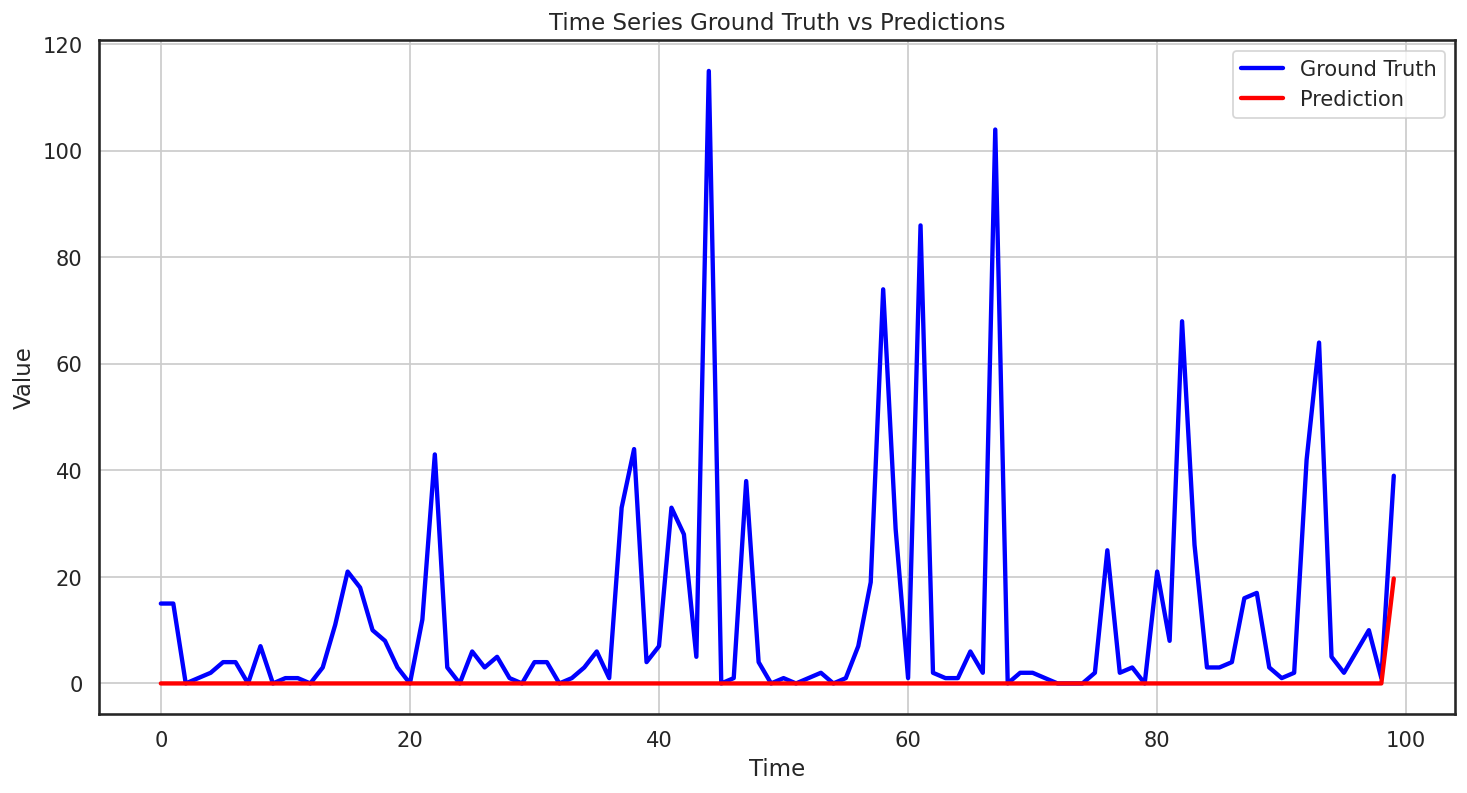

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming tss and forecasts are the lists containing your ground truths and predictions

# Combine all ground truth data into a single DataFrame
ground_truth = pd.concat(tss)

# Initialize an empty list to store prediction data
all_predictions = []

# Iterate through each SampleForecast object in forecasts
for forecast in forecasts:
    # Calculate the mean of the prediction samples
    pred_mean = forecast.samples.mean(axis=0)
    # Convert start_date to a Timestamp
    start_timestamp = forecast.start_date.to_timestamp()
    # Create a date range for the prediction period
    prediction_dates = pd.date_range(start=start_timestamp, periods=len(pred_mean), freq='H')
    # Create a DataFrame for the predictions
    pred_df = pd.DataFrame(pred_mean, index=prediction_dates, columns=['Prediction'])
    # Append the prediction DataFrame to the list
    all_predictions.append(pred_df)

# Combine all prediction DataFrames into a single DataFrame
predictions = pd.concat(all_predictions)

# Plotting the data
plt.figure(figsize=(14, 7))
preds = np.zeros(len(ground_truth.values))
preds[-len(predictions.values):] = predictions.values.squeeze()

# Number of points you want to select
num_points = 100

# Randomly select indices
random_indices = np.random.choice(len(ground_truth.values), num_points, replace=False)

# Sort indices to maintain the time order
random_indices.sort()

# Select the data points at those indices
gt = ground_truth.values[random_indices]

# Randomly select indices
random_indices = np.random.choice(len(preds), num_points, replace=False)

# Sort indices to maintain the time order
random_indices.sort()

# Select the data points at those indices
p = preds[random_indices]

plt.plot(gt, label='Ground Truth', color='blue')
plt.plot(p, label='Prediction', color='red')

# Adding titles and labels
plt.title('Time Series Ground Truth vs Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [50]:
ground_truth.values[-10:]

array([[2.],
       [0.],
       [1.],
       [2.],
       [4.],
       [3.],
       [3.],
       [0.],
       [2.],
       [3.]], dtype=float32)

In [51]:
predictions.values[-10:]

array([[2.764037 ],
       [1.6507818],
       [1.4931871],
       [4.041301 ],
       [3.2780857],
       [2.0145986],
       [2.6395097],
       [2.033095 ],
       [1.271327 ],
       [3.4177809]], dtype=float32)

## References

**Kollovieh, Marcel, et al.** "Predict, refine, synthesize: Self-guiding diffusion models for probabilistic time series forecasting." *Advances in Neural Information Processing Systems* 36 (2024).

**GitHub Repository:** [Amazon Science - Unconditional Time Series Diffusion](https://github.com/amazon-science/unconditional-time-series-diffusion)